In [1]:
import numpy as np
import lasagne
import matplotlib.pyplot as plt
from fwrf.models import *
from fwrf.utils import make_rf_table


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [8]:
%matplotlib inline

### Set up a fwrf with white noise training/val data

In [2]:
Ttrn,Tval,D,V,nmaps = 2003,301,17,4,8
deg_per_stim = 20
sf = 10

##feature maps
trn_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    trn_feature_map_dict[input_name] = np.random.random((Ttrn,D,sf*ii,sf*ii)).astype('float32')

val_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    val_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')

test_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    test_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')
    

##true rfs
bound = int((deg_per_stim-3)/2.)
true_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
true_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')

##random rfs
rand_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
rand_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')


##true feature weights
true_NU = np.random.random((D*nmaps,V)).astype('float32')

#random feature weights
rand_NU = np.random.random((D*nmaps,V)).astype('float32')

##fwrf model
true_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=true_rfs, NU=true_NU)
true_model.normalize(lambda: (yield trn_feature_map_dict))

##true outputs, trn/val
trn_voxel_activity = true_model.predict(trn_feature_map_dict).astype('float32')
val_voxel_activity = true_model.predict(val_feature_map_dict).astype('float32')
test_voxel_activity = true_model.predict(test_feature_map_dict).astype('float32')

##data generator: note these are functions that *return* generators, so we can reboot the generator whenever.
chunk_size = 100
trn_data_gen = lambda: (({k:v[ii:ii+chunk_size,:,:,:] for k,v in trn_feature_map_dict.iteritems()}, trn_voxel_activity[ii:ii+chunk_size,:]) for ii in range(0,Ttrn,chunk_size))
val_data_gen = lambda: (({k:v[ii:ii+chunk_size,:,:,:] for k,v in val_feature_map_dict.iteritems()}, val_voxel_activity[ii:ii+chunk_size,:]) for ii in range(0,Tval,chunk_size))       

##rf grid for coarse training
deg_per_radius = (1,deg_per_stim,12)
spacing = 2
rf_grid_df = make_rf_table(deg_per_stim,deg_per_radius,spacing,pix_per_stim = None)
G = rf_grid_df.shape[0]
rf_grid = {}
rf_grid['x0'] = rf_grid_df.x_deg.values.astype('float32')
rf_grid['y0'] = rf_grid_df.y_deg.values.astype('float32')
rf_grid['sig'] = rf_grid_df.deg_per_radius.values.astype('float32')
print G

1200


### Coarse vs. fine training (deterministic gradient descent)

#### train/test coarse

In [10]:
coarse_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=rand_rfs, NU=rand_NU)
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                        coarse=True,
                        rf_grid=rf_grid,
                        learning_rate=10e-5,
                        epochs=1,
                        num_iters = 700,
                        check_every=1,
                        print_stuff=True,
                        check_dims=False,
                        normalize=True,
                        consolidate=True)

will solve for: [feature_weights]
will update wrt: [feature_weights]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 4293
trn error: 418137408.000000
====iter: 1
number of improved models: 4292
trn error: 418014048.000000
====iter: 2
number of improved models: 4286
trn error: 417890944.000000
====iter: 3
number of improved models: 4290
trn error: 417765824.000000
====iter: 4
number of improved models: 4286
trn error: 417639680.000000
====iter: 5
number of improved models: 4285
trn error: 417515552.000000
====iter: 6
number of improved models: 4287
trn error: 417390272.000000
====iter: 7
number of improved models: 4287
trn error: 417264800.000000
====iter: 8
number of improved models: 4283
trn error: 417140128.000000
====iter: 9
number of improved models: 4289
trn error: 417014848.000000
====iter: 10
number of improved models: 4278
trn error: 416890240.000000
====iter: 11
number of improved models: 4283
trn error: 416765280.000000
====iter: 12
number of improved mode

In [11]:
test_pred_activity = coarse_model.predict(test_feature_map_dict)


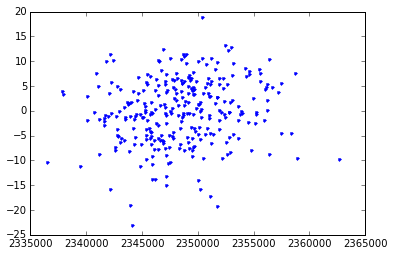

In [14]:
plt.plot(test_pred_activity[:,1], test_voxel_activity[:,1],'.')